<a href="https://colab.research.google.com/github/data-tamer2410/ds-weather-forecast/blob/master/weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

Build a neural network to predict weather data.

# Solving Task

In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Model
from keras import optimizers
from keras import layers
from keras import metrics
from keras.regularizers import L2
from keras.callbacks import EarlyStopping
%matplotlib inline

## Data Loading, Preparation and Visualization

In [ ]:
!head ./weatherAUS.csv

Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2008-12-01,Albury,13.4,22.9,0.6,NA,NA,W,44,W,WNW,20,24,71,22,1007.7,1007.1,8,NA,16.9,21.8,No,No
2008-12-02,Albury,7.4,25.1,0,NA,NA,WNW,44,NNW,WSW,4,22,44,25,1010.6,1007.8,NA,NA,17.2,24.3,No,No
2008-12-03,Albury,12.9,25.7,0,NA,NA,WSW,46,W,WSW,19,26,38,30,1007.6,1008.7,NA,2,21,23.2,No,No
2008-12-04,Albury,9.2,28,0,NA,NA,NE,24,SE,E,11,9,45,16,1017.6,1012.8,NA,NA,18.1,26.5,No,No
2008-12-05,Albury,17.5,32.3,1,NA,NA,W,41,ENE,NW,7,20,82,33,1010.8,1006,7,8,17.8,29.7,No,No
2008-12-06,Albury,14.6,29.7,0.2,NA,NA,WNW,56,W,W,19,24,55,23,1009.2,1005.4,NA,NA,20.6,28.9,No,No
2008-12-07,Albury,14.3,25,0,NA,NA,W,50,SW,W,20,24,49,19,1009.6,1008.2,1,NA,18.1,24.6,No,No
2008-12-08,Albury,7.7,26.7,0,NA,NA,W,35,SSE,W,6,17,48,19,1013.4,1010.1,NA,NA,16.3,25.5,No,No
2008-12-09,

In [ ]:
df = pd.read_csv('./weatherAUS.csv',sep=',',header=0,index_col=0)

In [ ]:
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

In [ ]:
df.iloc[0]

,2007-11-01
Location,Canberra
MinTemp,8.0
MaxTemp,24.3
Rainfall,0.0
Evaporation,3.4
Sunshine,6.3
WindGustDir,NW
WindGustSpeed,30.0
WindDir9am,SW
WindDir3pm,NW


In [ ]:
# Let's remove the unnecessary columns.
# Why am I deleting these columns?
# In the future, I will use this model for weather forecasting using data from an API.
# I have already found an API for my purposes, but it does not include such data, so I am removing them.
df.drop(columns=['Evaporation','WindGustDir','RainTomorrow','Sunshine'],inplace=True)

In [ ]:
# Let's check for missing values.
df.isna().sum()

,0
Location,0
MinTemp,1485
MaxTemp,1261
Rainfall,3261
WindGustSpeed,10263
WindDir9am,10566
WindDir3pm,4228
WindSpeed9am,1767
WindSpeed3pm,3062
Humidity9am,2654


In [ ]:
# Let's remove the rows with missing values.
df.dropna(inplace=True)


### Data visualization.

<Axes: xlabel='Pressure9am', ylabel='Rainfall'>

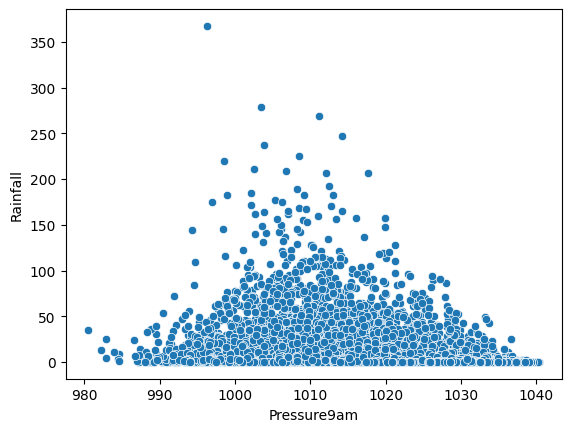

In [ ]:
# A graph showing the relationship between rainfall and pressure at 9 AM.
sns.scatterplot(df,x='Pressure9am',y='Rainfall')

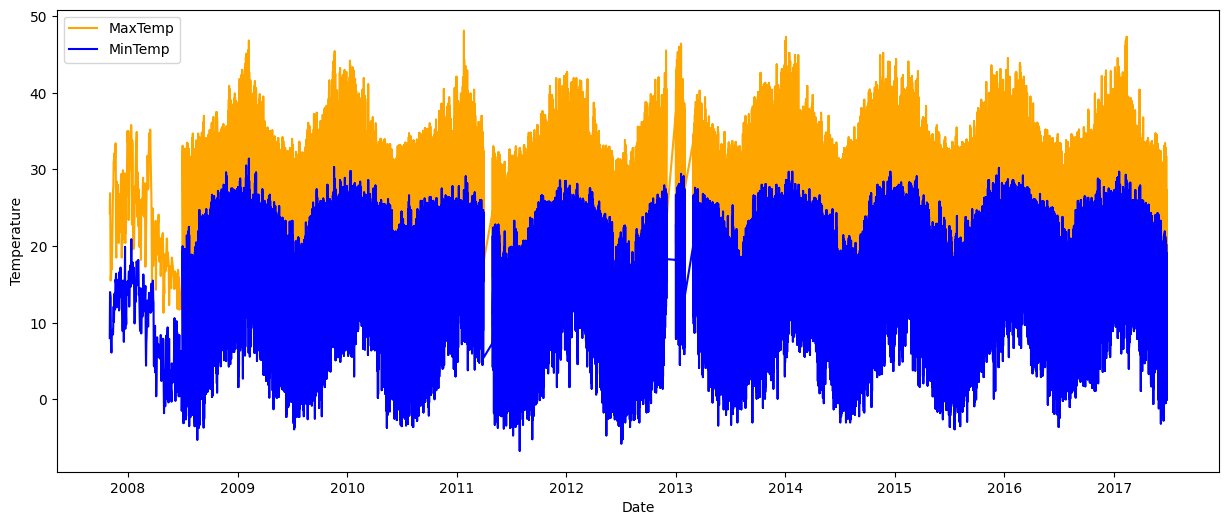

In [ ]:
# A graph of the maximum and minimum temperatures over time.
plt.figure(figsize=(15,6))

plt.plot(df.index,df['MaxTemp'],'orange',label='MaxTemp')
plt.plot(df.index,df['MinTemp'],'b',label='MinTemp')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
# Let's encode the wind direction values into numbers.
wind_dir_dict = {}
wind_dir_dict = {dir:i for i,dir in enumerate(df['WindDir9am'].unique())}

df[['WindDir9am','WindDir3pm']] = df[['WindDir9am','WindDir3pm']].map(lambda x: wind_dir_dict[x])
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Date,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,30.0,0,12,6.0,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No
2007-11-02,Canberra,14.0,26.9,3.6,39.0,1,15,4.0,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes
2007-11-03,Canberra,13.7,23.4,3.6,85.0,2,8,6.0,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes
2007-11-04,Canberra,13.3,15.5,39.8,54.0,3,15,30.0,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes
2007-11-05,Canberra,7.6,16.1,2.8,50.0,4,13,20.0,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes


In [ ]:
# Let's save the dictionary for future wind direction encoding.
with open('./dir_encoder.pkl','wb') as f:
    pickle.dump(wind_dir_dict, f)

In [ ]:
# Now let's encode RainToday.
df['RainToday'] = np.where(df['RainToday'] == 'Yes',1,0)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Date,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,30.0,0,12,6.0,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,0
2007-11-02,Canberra,14.0,26.9,3.6,39.0,1,15,4.0,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,1
2007-11-03,Canberra,13.7,23.4,3.6,85.0,2,8,6.0,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,1
2007-11-04,Canberra,13.3,15.5,39.8,54.0,3,15,30.0,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,1
2007-11-05,Canberra,7.6,16.1,2.8,50.0,4,13,20.0,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,1


In [ ]:
df.dtypes

,0
Location,object
MinTemp,float64
MaxTemp,float64
Rainfall,float64
WindGustSpeed,float64
WindDir9am,int64
WindDir3pm,int64
WindSpeed9am,float64
WindSpeed3pm,float64
Humidity9am,float64


In [ ]:
# Let's look at the correlation between the features.
df.drop(columns='Location').corr()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
MinTemp,1.000000,0.759253,0.111565,0.125808,-0.016829,0.026417,0.103890,0.111369,-0.211667,0.016985,-0.457196,-0.481252,0.072903,0.018802,0.907908,0.737091,0.037587
MaxTemp,0.759253,1.000000,-0.057210,0.036755,-0.005000,0.029676,-0.023311,-0.009996,-0.526827,-0.484781,-0.331112,-0.433065,-0.296035,-0.284689,0.899942,0.985475,-0.235241
Rainfall,0.111565,-0.057210,1.000000,0.122661,-0.005746,0.003642,0.070726,0.057166,0.247782,0.265673,-0.174274,-0.137449,0.205452,0.177504,0.020892,-0.060838,0.483550
WindGustSpeed,0.125808,0.036755,0.122661,1.000000,-0.009320,-0.005277,0.606396,0.684961,-0.168119,-0.021377,-0.434195,-0.386642,0.087361,0.122090,0.089016,0.000038,0.152312
WindDir9am,-0.016829,-0.005000,-0.005746,-0.009320,1.000000,0.059105,-0.046255,-0.019724,0.002802,-0.011072,-0.023478,-0.020932,-0.009004,0.001333,-0.010967,-0.005231,0.002182
WindDir3pm,0.026417,0.029676,0.003642,-0.005277,0.059105,1.000000,-0.041467,-0.002991,-0.013171,0.005583,-0.040154,-0.051675,-0.021617,-0.006570,0.040303,0.029116,-0.005738
WindSpeed9am,0.103890,-0.023311,0.070726,0.606396,-0.046255,-0.041467,1.000000,0.504287,-0.207331,-0.030477,-0.201416,-0.151180,0.039823,0.062214,0.044142,-0.034796,0.089722
WindSpeed3pm,0.111369,-0.009996,0.057166,0.684961,-0.019724,-0.002991,0.504287,1.000000,-0.076839,0.042667,-0.289274,-0.244142,0.072166,0.041954,0.086351,-0.032558,0.095420
Humidity9am,-0.211667,-0.526827,0.247782,-0.168119,0.002802,-0.013171,-0.207331,-0.076839,1.000000,0.704673,0.096273,0.158129,0.465421,0.373634,-0.454689,-0.519515,0.402581
Humidity3pm,0.016985,-0.484781,0.265673,-0.021377,-0.011072,0.005583,-0.030477,0.042667,0.704673,1.000000,-0.061667,0.024027,0.530492,0.533773,-0.203894,-0.531003,0.402053


The model will predict the following indicators for the next day based on the previous 7 days of weather data. Below is the list of features, their units, and data ranges:

1. **MaxTemp**: Maximum temperature of the day (°C).  
2. **MinTemp**: Minimum temperature of the day (°C).  
3. **Pressure3pm**: Atmospheric pressure at 3 PM (hPa).  
4. **Pressure9am**: Atmospheric pressure at 9 AM (hPa).  
5. **Rainfall**: Amount of rainfall (mm).  
6. **Temp3pm**: Temperature at 3 PM (°C).  
7. **Temp9am**: Temperature at 9 AM (°C).  
8. **WindGustSpeed**: Maximum wind gust speed (km/h).  
9. **WindSpeed3pm**: Wind speed at 3 PM (km/h).  
10. **WindSpeed9am**: Wind speed at 9 AM (km/h).
11. **RainToday**: Whether it rained today (0 = No, 1 = Yes).   

I will also consider that there are multiple locations in the dataset, as this is important for proper data preparation.

The model will accept the following input parameters in this order:  
**MinTemp, MaxTemp, Rainfall, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm, WindDir9am, WindDir3pm, Humidity9am, Humidity3pm, Cloud9am, Cloud3pm, RainToday.**

In [ ]:
# We will fix the order of submitting signs to the network for convenience,
# but for now we will leave the 'Location' column blank, because it will still be needed.
columns = ['Location',
           'MinTemp',
           'MaxTemp',
           'Rainfall',
           'WindGustSpeed',
           'WindSpeed9am',
           'WindSpeed3pm',
           'Pressure9am',
           'Pressure3pm',
           'Temp9am',
           'Temp3pm',
           'WindDir9am',
           'WindDir3pm',
           'Humidity9am',
           'Humidity3pm',
           'Cloud9am',
           'Cloud3pm',
           'RainToday']
df = df[columns]

In [ ]:
# The model will take data from the last 7 days and predict the data for the next 8th day.
locations = df['Location'].unique()
n_features = len(df.columns) - 1 # The number of features excluding the location.
target_names = ['MaxTemp',
                'MinTemp',
                'Pressure3pm',
                'Pressure9am',
                'Rainfall',
                'Temp3pm',
                'Temp9am',
                'WindGustSpeed',
                'WindSpeed3pm',
                'WindSpeed9am',
                'RainToday']

features = []
targets = [[] for _ in range(len(target_names))] # For each output, we create a separate list.
for location in locations:
    location_df = df[df['Location'] == location]
    for start_date in location_df.index:
        end_date = start_date + timedelta(days=7)
        days8_range = pd.date_range(start=start_date,end=end_date, freq='D')
        days8_df = location_df.loc[start_date:end_date].copy()

        if np.in1d(days8_range,days8_df.index).all():
            days8_df.drop(columns='Location', inplace=True)
            features.append(days8_df.iloc[:-1,:])
            target_day = days8_df.iloc[-1,:]
            for i,el in enumerate(target_day[target_names]):
                targets[i].append(el)

features = np.array(features,dtype='float32')
targets = [np.array(l,dtype='float32') for l in targets]

In [ ]:
targets

[array([17. , 19.5, 22.8, ..., 27.7, 18.8, 26. ], dtype=float32),
 array([ 8.3,  8.8,  8.4, ..., 10.5,  9.7, 17.3], dtype=float32),
 array([1024.2, 1022.7, 1020.7, ..., 1014.9, 1028.5, 1013.5], dtype=float32),
 array([1026.2, 1026.1, 1024.1, ..., 1019.1, 1031.5, 1015.7], dtype=float32),
 array([ 0. ,  0. , 16.2, ...,  0. ,  0.2,  0. ], dtype=float32),
 array([15.5, 18.9, 21.7, ..., 27. , 17. , 23. ], dtype=float32),
 array([12.1, 14.1, 13.3, ..., 17.8, 13.6, 22.5], dtype=float32),
 array([41., 48., 31., ..., 43., 31., 52.], dtype=float32),
 array([24., 17.,  6., ..., 15., 15., 17.], dtype=float32),
 array([11., 19.,  7., ..., 22.,  4., 17.], dtype=float32),
 array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
# Data normalization.
scaler = StandardScaler()

features_reshaped = features.reshape(features.shape[0], -1) # Reshaping the features into a 2D format.
features_scaler = scaler.fit_transform(features_reshaped)
features = features_scaler.reshape(features.shape) # Reshaping back to the required size.

In [ ]:
# Let's save the normalization parameters for further prediction.
with open('./standard_scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [ ]:
# Splitting data into training, test and validation sets while considering class balance in the target variable RainToday.

def split_data(features,target_list,stratify,test_size):
    x_train, x_test, y_train, y_test = [], [], [], []
    for cls in np.unique(stratify):
        ids = np.where(stratify == cls)[0]
        np.random.shuffle(ids)

        n_tests = int(len(ids) * test_size)

        x_train.append(features[ids[:-n_tests]])
        x_test.append(features[ids[-n_tests:]])

        y_train.append([arr[ids[:-n_tests]] for arr in target_list])
        y_test.append([arr[ids[-n_tests:]] for arr in target_list])

    x_train = np.vstack(x_train,dtype='float32')
    x_test = np.vstack(x_test,dtype='float32')

    y_train = [np.concatenate([l1,l2],dtype='float32') for l1,l2 in zip(*y_train)]
    y_test = [np.concatenate([l1,l2],dtype='float32') for l1,l2 in zip(*y_test)]
    return x_train, x_test, y_train, y_test

x_train, x_test_val, y_train, y_test_val = split_data(features,targets,targets[-1],test_size=0.25)
x_test, x_val, y_test, y_val = split_data(x_test_val,y_test_val,y_test_val[-1],test_size=0.5)

## Construction and Training of a Neural Network

I plan to use a recurrent neural network (RNN) to analyze data from the past seven days to predict metrics for the next day.

This model will account for the temporal dependency of weather data, ensuring more accurate predictions.


### Model Output Information:

1. **MaxTemp**: Maximum temperature of the day (°C). (regression)  
2. **MinTemp**: Minimum temperature of the day (°C). (regression)
3. **Pressure3pm**: Atmospheric pressure at 3 PM (hPa). (regression)   
4. **Pressure9am**: Atmospheric pressure at 9 AM (hPa). (regression)  
5. **Rainfall**: Amount of rainfall (mm). (regression)  
6. **Temp3pm**: Temperature at 3 PM (°C). (regression)  
7. **Temp9am**: Temperature at 9 AM (°C). (regression)  
8. **WindGustSpeed**: Maximum wind gust speed (km/h). (regression)  
9. **WindSpeed3pm**: Wind speed at 3 PM (km/h). (regression)  
10. **WindSpeed9am**: Wind speed at 9 AM (km/h). (regression)
11. **RainToday**: Whether it rained today (0 = No, 1 = Yes). (binary classification)

In [ ]:
# Construction model
input = layers.Input(shape=features.shape[1:])  # Assuming 7 days of data and 11 features

x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input)
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dense(32,activation='relu')(x)


# Regression Outputs
out_MaxTemp = layers.Dense(1,activation='linear',name='MaxTemp_reg')(x)
out_MinTemp = layers.Dense(1,activation='linear',name='MinTemp_reg')(x)
out_Pressure3pm = layers.Dense(1,activation='linear',name='Pressure3pm_reg')(x)
out_Pressure9am = layers.Dense(1,activation='linear',name='Pressure9am_reg')(x)
out_Rainfall = layers.Dense(1,kernel_regularizer=L2(0.01),activation='linear',name='Rainfall_reg')(x)
out_Temp3pm = layers.Dense(1,activation='linear',name='Temp3pm_reg')(x)
out_Temp9am = layers.Dense(1,activation='linear',name='Temp9am_reg')(x)
out_WindGustSpeed = layers.Dense(1,activation='linear',name='WindGustSpeed_reg')(x)
out_WindSpeed3pm = layers.Dense(1,activation='linear',name='WindSpeed3pm_reg')(x)
out_WindSpeed9am = layers.Dense(1,activation='linear',name='WindSpeed9am_reg')(x)

# Binary Classification Output
out_RainToday = layers.Dense(1,kernel_regularizer=L2(0.01),activation='sigmoid',name='RainToday_binary')(x)

# Combine all outputs
model = Model(
    inputs=input,
    outputs=[
        out_MaxTemp,
        out_MinTemp,
        out_Pressure3pm,
        out_Pressure9am,
        out_Rainfall,
        out_Temp3pm,
        out_Temp9am,
        out_WindGustSpeed,
        out_WindSpeed3pm,
        out_WindSpeed9am,
        out_RainToday
    ]
)

# Compile the Model
model.compile(
    optimizer=optimizers.Nadam(learning_rate=0.001),
    loss={
        'MaxTemp_reg': 'mse',
        'MinTemp_reg': 'mse',
        'Pressure3pm_reg': 'mse',
        'Pressure9am_reg': 'mse',
        'Rainfall_reg': 'mse',
        'Temp3pm_reg': 'mse',
        'Temp9am_reg': 'mse',
        'WindGustSpeed_reg': 'mse',
        'WindSpeed3pm_reg': 'mse',
        'WindSpeed9am_reg': 'mse',
        'RainToday_binary': 'binary_crossentropy'
    },
    metrics={
        'MaxTemp_reg': 'mae',
        'MinTemp_reg': 'mae',
        'Pressure3pm_reg': 'mae',
        'Pressure9am_reg': 'mae',
        'Rainfall_reg': 'mae',
        'Temp3pm_reg': 'mae',
        'Temp9am_reg': 'mae',
        'WindGustSpeed_reg': 'mae',
        'WindSpeed3pm_reg': 'mae',
        'WindSpeed9am_reg': 'mae',
        'RainToday_binary': 'accuracy'
    }
)

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7, 17)]              0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 7, 256)               149504    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  394240    ['bidirectional[0][0]']       
 onal)                                                                                            
                                                                                              

In [ ]:
batch_size = 32
stopper = EarlyStopping(monitor='val_loss',restore_best_weights=True,patience=5)

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=100,
                    validation_data=(x_val,y_val),
                    callbacks=[stopper])

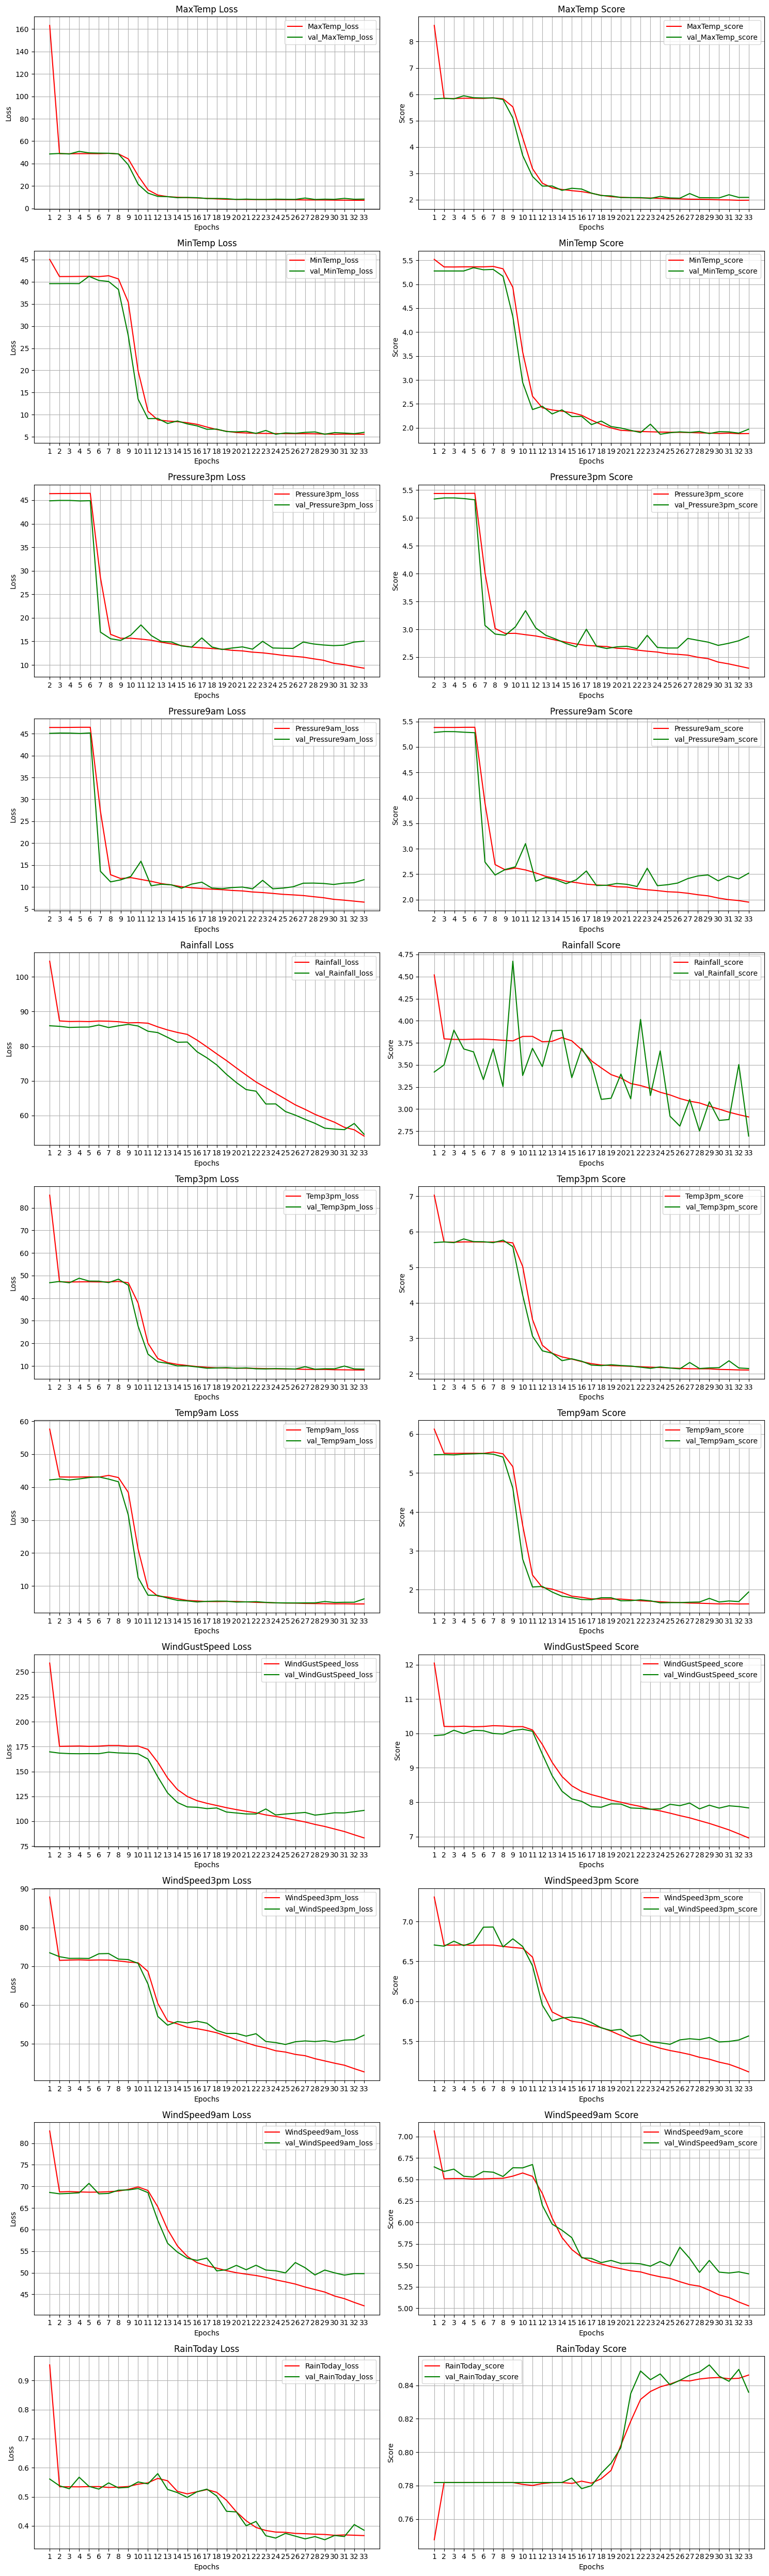

In [ ]:
# Let's visualize the training of the model.
# In the first epoch of the pressure outputs, the error is very large and then drops sharply,
# so it is impossible to evaluate the learning curve as the graph becomes flat,
# so I do not take into account the results of the first epoch, I will also do the same for the general error graph.

history = history.history
nrows = 11

fig, axs = plt.subplots(nrows=nrows,ncols=2,figsize=(15,50))

for i_row,name in enumerate(target_names):
    x = np.arange(1,len(history['loss']) + 1)
    for key in history.keys():
        if all([key.startswith(name),key.endswith('loss')]):
            loss = history[key]
        elif all([key.startswith('val_' + name),key.endswith('loss')]):
            val_loss = history[key]
        elif key.startswith(name) and any([key.endswith('mae'),key.endswith('accuracy')]):
            score = history[key]
        elif key.startswith('val_' + name) and any([key.endswith('mae'),key.endswith('accuracy')]):
            val_score = history[key]

    if name.startswith('Pressure'):
        x = np.arange(2,len(history['loss']) + 1)
        loss = loss[1:]
        val_loss = val_loss[1:]
        score = score[1:]
        val_score = val_score[1:]

    axs[i_row,0].plot(x,loss,'r',label=f'{name}_loss')
    axs[i_row,0].plot(x,val_loss,'g',label=f'val_{name}_loss')

    axs[i_row,1].plot(x,score,'r',label=f'{name}_score')
    axs[i_row,1].plot(x,val_score,'g',label=f'val_{name}_score')

    axs[i_row,0].set_title(f'{name} Loss')
    axs[i_row,1].set_title(f'{name} Score')
    axs[i_row,0].set_ylabel('Loss')
    axs[i_row,1].set_ylabel('Score')
    axs[i_row,0].set_xlabel('Epochs')
    axs[i_row,1].set_xlabel('Epochs')
    axs[i_row,0].legend()
    axs[i_row,1].legend()
    axs[i_row,0].grid()
    axs[i_row,1].grid()
    axs[i_row,0].set_xticks(x)
    axs[i_row,1].set_xticks(x)

plt.tight_layout()
plt.show()

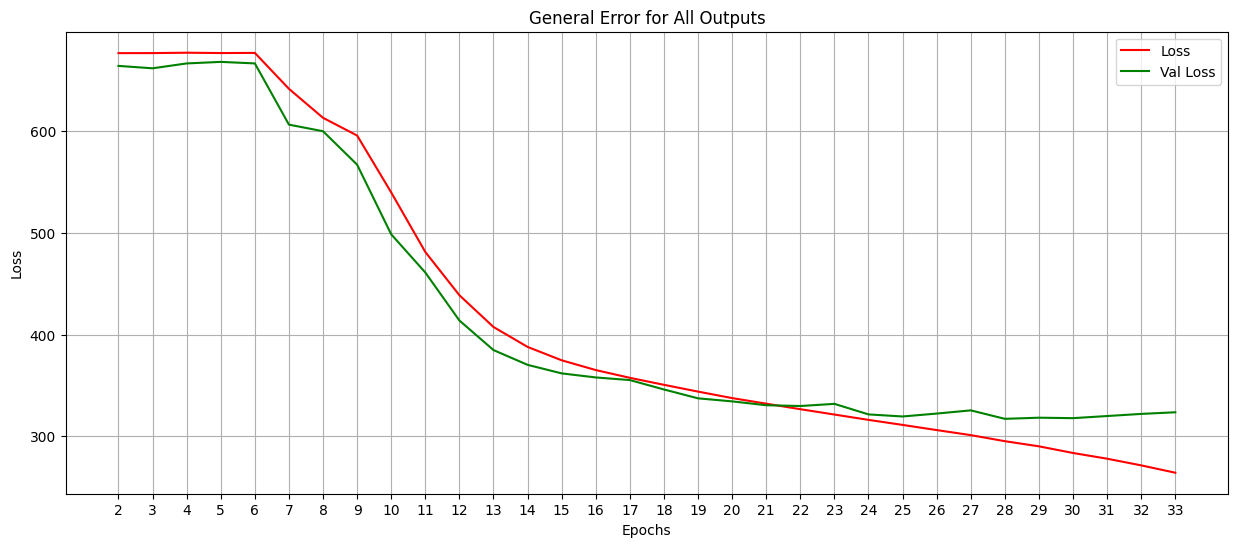

In [ ]:
# Now we visualize the general error for all outputs.
x = np.arange(2, len(history['loss']) + 1)
loss = history['loss'][1:]
val_loss = history['val_loss'][1:]


plt.figure(figsize=(15,6))

plt.plot(x,loss,'r',label='Loss')
plt.plot(x,val_loss,'g',label='Val Loss')

plt.title('General Error for All Outputs')
plt.xticks(x)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Model Testing
_ = model.evaluate(x_test,y_test)

163/163 [==============================] - 1s 8ms/step - loss: 328.9554 - MaxTemp_reg_loss: 7.9344 - MinTemp_reg_loss: 6.2196 - Pressure3pm_reg_loss: 14.9377 - Pressure9am_reg_loss: 11.3454 - Rainfall_reg_loss: 54.9164 - Temp3pm_reg_loss: 8.7558 - Temp9am_reg_loss: 4.9557 - WindGustSpeed_reg_loss: 118.6510 - WindSpeed3pm_reg_loss: 54.1412 - WindSpeed9am_reg_loss: 46.7101 - RainToday_binary_loss: 0.3758 - MaxTemp_reg_mae: 2.0796 - MinTemp_reg_mae: 1.9358 - Pressure3pm_reg_mae: 2.8863 - Pressure9am_reg_mae: 2.5228 - Rainfall_reg_mae: 2.8083 - Temp3pm_reg_mae: 2.1836 - Temp9am_reg_mae: 1.6918 - WindGustSpeed_reg_mae: 8.1557 - WindSpeed3pm_reg_mae: 5.7606 - WindSpeed9am_reg_mae: 5.2679 - RainToday_binary_accuracy: 0.8370


In [ ]:
# Model Saving
model.save('./weather_forecast.h5')

In [ ]:
# We compare the predictions of the model on one example.
y_pred = model.predict(x_test[2222].reshape(1, 7, 17))

1/1 [==============================] - 0s 26ms/step


In [ ]:
ex1_targets = [arr[2222] for arr in y_test]

for name, pred, target in zip(target_names,y_pred,ex1_targets):
    pred = pred[0][0]
    print(f'{name}:')
    if name == 'RainToday':
        pred = 'Yes' if pred >= 0.5 else 'No'
        target = 'Yes' if target else 'No'
        print(f'Pred: {pred}; Target: {target}\n')
    else:
        print(f'Pred: {pred:.2f}; Target: {target:.2f}\n')

MaxTemp:
Pred: 37.12; Target: 36.00

MinTemp:
Pred: 21.35; Target: 21.10

Pressure3pm:
Pred: 1015.34; Target: 1017.80

Pressure9am:
Pred: 1019.41; Target: 1021.10

Rainfall:
Pred: -0.10; Target: 0.00

Temp3pm:
Pred: 35.60; Target: 34.00

Temp9am:
Pred: 27.24; Target: 26.40

WindGustSpeed:
Pred: 38.07; Target: 54.00

WindSpeed3pm:
Pred: 16.16; Target: 15.00

WindSpeed9am:
Pred: 14.38; Target: 9.00

RainToday:
Pred: No; Target: No



## Conclusion

The project demonstrates promising results for weather prediction using a recurrent neural network (RNN) with a bidirectional LSTM architecture. The model is trained on weather data from the past 7 days to predict several weather parameters for the next day, including temperature, pressure, wind speed, and rainfall.

The neural network has been successfully built and trained, showing encouraging accuracy, especially for predicting continuous variables like temperature and pressure. However, the binary classification output for whether it will rain today (RainToday) is also being predicted with good performance, indicating the model's ability to distinguish between rainy and non-rainy days.